# Apple Health & Freestyle Libre 3 Data Analysis
## 05 - Libre Glucose Exploratory Analysis

This notebook focuses exclusively on the processed FreeStyle Libre 3 glucose readings to understand glycemic control, sensor behavior, and temporal patterns before blending with Apple Health metrics.

**Notebook objectives:**
- Load the cleaned Libre glucose export and harmonize datetime features
- Audit data coverage, data quality, and time-in-range performance
- Explore daily trends, rate-of-change dynamics, and circadian patterns
- Produce reusable aggregates to join with Apple Health features later

In [1]:
# Import libraries and configure visualization defaults
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Markdown, display

sns.set_theme(style="whitegrid", palette="deep")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)
print("✅ Libraries imported")

✅ Libraries imported


### 1. Load Libre glucose dataset

In [2]:
data_dir = Path("../data/processed")
glucose_path = data_dir / "glucose_cleaned.csv"

glucose_df = pd.read_csv(
    glucose_path,
    parse_dates=["timestamp"],
    dtype={"glucose_range": "category", "glucose_source": "category"},
)
glucose_df = glucose_df.dropna(subset=["timestamp"]).copy()
glucose_df["timestamp"] = glucose_df["timestamp"].dt.tz_localize(None)

glucose_df["date"] = glucose_df["timestamp"].dt.floor("D")
glucose_df["hour_of_day"] = glucose_df["timestamp"].dt.hour
glucose_df["day_name"] = glucose_df["timestamp"].dt.day_name()
glucose_df["weekofyear"] = glucose_df["timestamp"].dt.isocalendar().week.astype(int)
glucose_df["is_weekend"] = glucose_df["day_name"].isin(["Saturday", "Sunday"])
glucose_df["glucose_rate_change"] = pd.to_numeric(
    glucose_df["glucose_rate_change"], errors="coerce"
)

record_count = len(glucose_df)
time_span = glucose_df["timestamp"].agg(["min", "max"])
print(
    f"📦 Loaded {record_count:,} glucose readings from {time_span['min'].date()} to {time_span['max'].date()}"
)

📦 Loaded 4,151 glucose readings from 2025-08-16 to 2025-08-30


### 2. Data coverage and sampling cadence

In [3]:
coverage_summary = {
    "records": len(glucose_df),
    "days_covered": glucose_df["date"].nunique(),
    "median_interval_minutes": glucose_df["timestamp"]
    .diff()
    .dt.total_seconds()
    .dropna()
    .median()
    / 60,
    "scan_share_pct": (glucose_df["glucose_source"].eq("scan").mean() * 100),
    "historic_share_pct": (glucose_df["glucose_source"].eq("historic").mean() * 100),
}
display(pd.DataFrame.from_dict(coverage_summary, orient="index", columns=["value"]))

display(Markdown("**Example records:**"))
display(glucose_df.head())

,value
records,4151.00
days_covered,15.00
median_interval_minutes,5.00
scan_share_pct,1.52
historic_share_pct,98.48


**Example records:**

,device,serial_number,timestamp,record_type,glucose_mg_dl,scan_glucose_mg_dl,Non-numeric Rapid-Acting Insulin,rapid_acting_insulin_units,Non-numeric Food,carbohydrates_grams,Carbohydrates (servings),Non-numeric Long-Acting Insulin,long_acting_insulin_units,notes,strip_glucose_mg_dl,ketone_mmol_l,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units),glucose_value,glucose_source,glucose_rate_change,glucose_trend,hour,day_of_week,is_weekend,glucose_range,date,hour_of_day,day_name,weekofyear
0,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:20:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,NaN,stable,13,5,True,normal,2025-08-16,13,Saturday,33
1,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:21:00,1,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0,scan,4.00,rising_fast,13,5,True,normal,2025-08-16,13,Saturday,33
2,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:25:00,0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,historic,-1.25,stable,13,5,True,normal,2025-08-16,13,Saturday,33
3,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:30:00,0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.0,historic,0.60,stable,13,5,True,normal,2025-08-16,13,Saturday,33
4,FreeStyle Libre 3,03EE5610-75AC-4A63-860F-A3A70A27AD2F,2025-08-16 13:35:00,0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,historic,-0.40,stable,13,5,True,normal,2025-08-16,13,Saturday,33


### 3. Data quality checks

In [4]:
missing_pct = glucose_df.isna().mean().sort_values(ascending=False) * 100
display(Markdown("**Columns with missingness (% of rows):**"))
display(missing_pct[missing_pct > 0].round(2).to_frame(name="pct_missing"))

duplicate_rows = glucose_df.duplicated(subset=["timestamp", "glucose_value"]).sum()
print(f"🔍 Potential duplicate timestamp+value rows: {duplicate_rows}")

**Columns with missingness (% of rows):**

,pct_missing
ketone_mmol_l,100.00
carbohydrates_grams,100.00
User Change Insulin (units),100.00
Correction Insulin (units),100.00
Meal Insulin (units),100.00
strip_glucose_mg_dl,100.00
notes,100.00
long_acting_insulin_units,100.00
Carbohydrates (servings),100.00
Non-numeric Long-Acting Insulin,100.00


🔍 Potential duplicate timestamp+value rows: 0


### 4. Glucose distribution and descriptive statistics

,glucose_value
count,4151.00
mean,90.42
std,11.07
min,53.00
5%,74.00
25%,83.00
50%,90.00
75%,96.00
95%,110.00
max,153.00


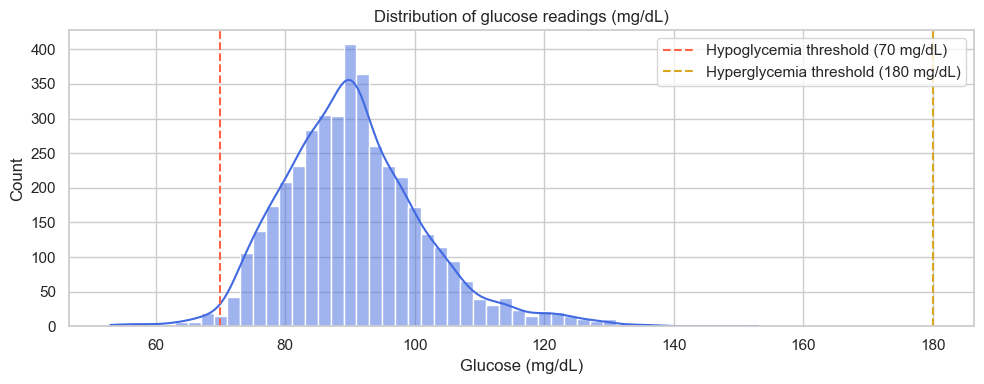

In [5]:
glucose_stats = glucose_df["glucose_value"].describe(
    percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
)
display(glucose_stats.to_frame(name="glucose_value"))

plt.figure(figsize=(10, 4))
sns.histplot(glucose_df["glucose_value"], bins=50, kde=True, color="royalblue")
plt.axvline(
    70, color="tomato", linestyle="--", label="Hypoglycemia threshold (70 mg/dL)"
)
plt.axvline(
    180, color="goldenrod", linestyle="--", label="Hyperglycemia threshold (180 mg/dL)"
)
plt.title("Distribution of glucose readings (mg/dL)")
plt.xlabel("Glucose (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Time-in-range performance

In [6]:
tir_labels = {
    "very_low": "Very Low (<54)",
    "low": "Low (54-69)",
    "normal": "In Range (70-180)",
    "high": "High (181-250)",
    "very_high": "Very High (>250)",
}
tir_raw = glucose_df["glucose_range"].astype("string").str.lower()
tir_raw = tir_raw.replace({"<NA>": "unknown", "nan": "unknown"})
glucose_df["tir_bucket"] = tir_raw.fillna("unknown")
tir_summary = (
    glucose_df["tir_bucket"]
    .map(lambda x: tir_labels.get(x, x.title()))
    .value_counts(normalize=True)
    .mul(100)
    .sort_values(ascending=False)
)
display(Markdown("**Overall time in range (% of readings):**"))
display(tir_summary.round(2).to_frame(name="pct"))

daily_tir = (
    glucose_df.groupby("date")["tir_bucket"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("pct")
    .reset_index()
)
daily_tir["tir_bucket"] = daily_tir["tir_bucket"].map(
    lambda x: tir_labels.get(x, x.title())
)

fig = px.area(
    daily_tir,
    x="date",
    y="pct",
    color="tir_bucket",
    title="Daily time-in-range distribution",
    groupnorm="percent",
    labels={"date": "Date", "pct": "Percent of readings", "tir_bucket": "Range"},
)
fig.update_layout(legend_title_text="Glucose range")
fig.show()

**Overall time in range (% of readings):**

,pct
tir_bucket,
In Range (70-180),98.75
Low (54-69),1.18
Very Low (<54),0.07


### 6. Daily glucose trends

In [7]:
daily_metrics = (
    glucose_df.groupby("date")["glucose_value"]
    .agg(["mean", "median", "min", "max"])
    .rename(
        columns={
            "mean": "mean_mg_dl",
            "median": "median_mg_dl",
            "min": "min_mg_dl",
            "max": "max_mg_dl",
        }
    )
)
display(daily_metrics.tail())

fig = px.line(
    daily_metrics.reset_index(),
    x="date",
    y=["mean_mg_dl", "median_mg_dl"],
    title="Daily mean vs median glucose",
    labels={"value": "Glucose (mg/dL)", "variable": "Statistic"},
)
fig.add_hrect(y0=70, y1=180, fillcolor="lightgreen", opacity=0.2, line_width=0)
fig.show()

,mean_mg_dl,median_mg_dl,min_mg_dl,max_mg_dl
date,,,,
2025-08-26,84.61,81.0,69.0,126.0
2025-08-27,90.21,87.0,67.0,138.0
2025-08-28,91.21,91.0,73.0,127.0
2025-08-29,91.76,90.0,59.0,132.0
2025-08-30,95.87,92.0,64.0,124.0


### 7. Circadian patterns

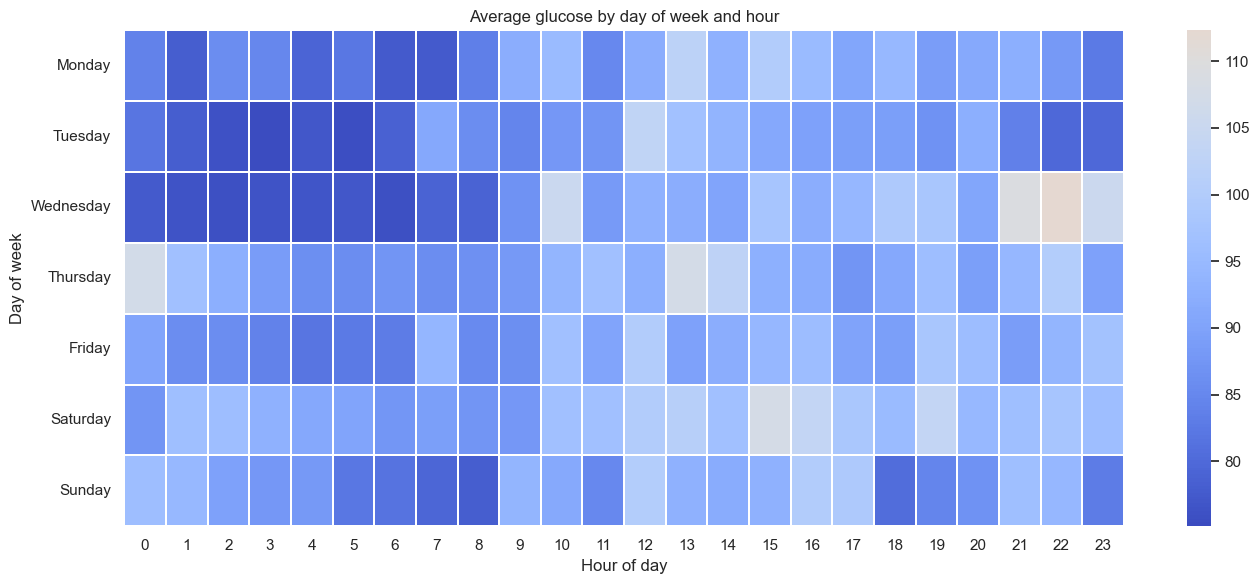

In [8]:
hourly_pattern = (
    glucose_df.groupby(["day_name", "hour_of_day"])["glucose_value"]
    .mean()
    .reset_index()
)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
hourly_pivot = hourly_pattern.pivot(
    index="day_name", columns="hour_of_day", values="glucose_value"
).reindex(day_order)
plt.figure(figsize=(14, 6))
sns.heatmap(hourly_pivot, cmap="coolwarm", center=110, linewidths=0.3)
plt.title("Average glucose by day of week and hour")
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.tight_layout()
plt.show()

### 8. Rate-of-change dynamics

,rate_change_mg_dl_per_min
count,4.15e+03
mean,-3.49e-03
std,1.03e+00
min,-1.70e+01
5%,-1.00e+00
50%,0.00e+00
95%,1.00e+00
max,3.10e+01


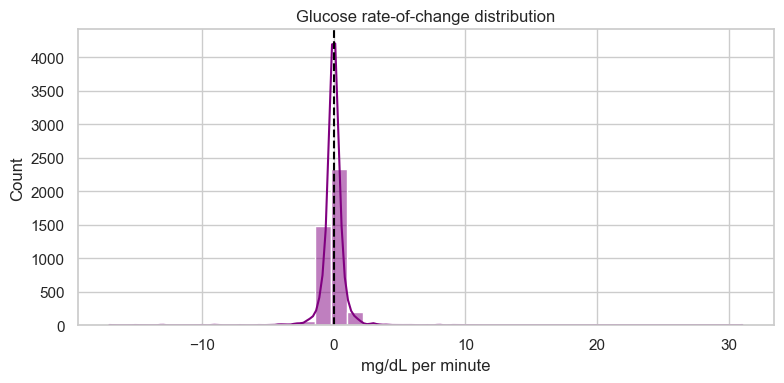

,count
trend,
stable,3879
rising,191
falling_fast,44
rising_fast,37


In [9]:
roc = glucose_df["glucose_rate_change"].dropna()
if roc.empty:
    print("⚠️ No rate-of-change data available in this export.")
else:
    display(
        roc.describe(percentiles=[0.05, 0.5, 0.95]).to_frame(
            name="rate_change_mg_dl_per_min"
        )
    )
    plt.figure(figsize=(8, 4))
    sns.histplot(roc, bins=40, kde=True, color="purple")
    plt.axvline(0, color="black", linestyle="--")
    plt.title("Glucose rate-of-change distribution")
    plt.xlabel("mg/dL per minute")
    plt.tight_layout()
    plt.show()

    trend_counts = (
        glucose_df["glucose_trend"]
        .value_counts()
        .rename_axis("trend")
        .to_frame(name="count")
    )
    display(trend_counts)

### 9. Rolling variability and sustained patterns

In [10]:
daily_series = (
    glucose_df.set_index("timestamp")["glucose_value"]
    .resample("15T")
    .mean()
    .interpolate()
)
rolling_window = 96  # 15-minute samples across one day
rolling_mean = daily_series.rolling(
    rolling_window, min_periods=rolling_window // 2
).mean()
rolling_std = daily_series.rolling(
    rolling_window, min_periods=rolling_window // 2
).std()

fig = px.line(
    pd.DataFrame(
        {
            "timestamp": rolling_mean.index,
            "rolling_mean": rolling_mean,
            "rolling_std": rolling_std,
        }
    ),
    x="timestamp",
    y=["rolling_mean", "rolling_std"],
    title="Rolling 24-hour glucose mean and variability",
    labels={"value": "mg/dL", "variable": "Metric"},
)
fig.show()

/var/folders/pj/9229dfxn08b9q2x4mrfmj55r0000gn/T/ipykernel_8413/3961770209.py:3: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



### 10. Observations and next steps
- Inspect the distribution and TIR plots to confirm the share of readings within the 70-180 mg/dL target band.
- Review circadian heatmaps for recurring high-variability hours that could benefit from habit or meal adjustments.
- Rate-of-change statistics highlight how aggressively glucose moves after scans; align this with insulin and carb logs.
- Export these aggregates or join them with Apple Health summaries in future notebooks for multi-sensor insights.